# LAB 5. Hypothesis testing. Green taxi case

Test varios hypothesis about ridership volume and trip characteristics for green taxi trips in 2018-2020. 

Does the ridership decline over time? Does it depend on the day of the week and time of the day? Does the distribution of the trip parameters (distance, time, speed) depend on the day of the week and borough?

In [1]:
#import the modules
import pandas as pd
import geopandas as gpd
import urllib.request
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#create the folders
if not os.path.exists('Data'):
    !mkdir Data
if not os.path.exists('Data/TLC'):
    !mkdir Data/TLC

In [4]:
#download green taxi data if not downloaded yet; might take a couple of minutes
for year in [2018,2019,2020]:
    for month in range(1,13):
        if year == 2020 and month > 6:
            pass
        else:
            file = 'green_tripdata_'+str(year)+'-'+str(month).zfill(2)+'.csv'
            if not os.path.exists('Data/TLC/'+file):
                url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'+file
                urllib.request.urlretrieve(url,'Data/TLC/'+file)
print('done')

done


In [6]:
#concatenate all the files into a single dataframe - takes up to a minute
files = os.listdir('./Data/TLC/')
dfList = []

for index,filename in enumerate(files):
    if '.csv' in filename:
        if index == 0:
            df = pd.read_csv('./Data/TLC/'+filename, index_col=None)
        else:
            df = pd.read_csv('./Data/TLC/'+filename, index_col=None, header=0)
        dfList.append(df)
dfTaxi = pd.concat(dfList, axis=0, ignore_index=True)

In [7]:
dfTaxi.columns

Index(['DOLocationID', 'PULocationID', 'RatecodeID', 'VendorID',
       'congestion_surcharge', 'ehail_fee', 'extra', 'fare_amount',
       'improvement_surcharge', 'lpep_dropoff_datetime',
       'lpep_pickup_datetime', 'mta_tax', 'passenger_count', 'payment_type',
       'store_and_fwd_flag', 'tip_amount', 'tolls_amount', 'total_amount',
       'trip_distance', 'trip_type'],
      dtype='object')

In [8]:
#take care of the timestamp types
dfTaxi['lpep_pickup_datetime'] = pd.to_datetime(dfTaxi['lpep_pickup_datetime'])
dfTaxi['lpep_dropoff_datetime'] = pd.to_datetime(dfTaxi['lpep_dropoff_datetime'])

In [9]:
#extract date, year, day of the week and hour (takes some time around half a minute)
dfTaxi['Date'] = dfTaxi['lpep_pickup_datetime'].dt.date
dfTaxi['Month'] = dfTaxi['lpep_pickup_datetime'].dt.month
dfTaxi['Year'] = dfTaxi['lpep_pickup_datetime'].dt.year
dfTaxi['DOW'] = dfTaxi['lpep_pickup_datetime'].dt.dayofweek
dfTaxi['Hour'] = dfTaxi['lpep_pickup_datetime'].dt.hour
dfTaxi = dfTaxi.loc[dfTaxi['Year'].isin([2018,2019,2020])]

In [10]:
#calculate trip duration in minutes
dfTaxi['trip_duration'] = (dfTaxi['lpep_dropoff_datetime'] - dfTaxi['lpep_pickup_datetime'])
dfTaxi['trip_duration'] = dfTaxi['trip_duration'].dt.total_seconds() / 60

In [11]:
dfTaxi['speed'] = dfTaxi['trip_distance'] / (dfTaxi['trip_duration'] / 60) #avg trip speed in miles per hoiur

In [12]:
len(dfTaxi) #original number of records

16076540

In [13]:
#sanity filtering
dfTaxi = dfTaxi[(dfTaxi['Date']<=pd.to_datetime('6/30/2020')) & (dfTaxi.trip_distance < 100)
           & (dfTaxi.speed <= 80) & (dfTaxi.speed >= 1) & (dfTaxi.trip_duration <= 100) & (dfTaxi.trip_duration >= 1)]
len(dfTaxi) #remaining records

15537613

In [14]:
#daily total trip counts and cumulative duration and distance traveled
dfTaxiDaily = dfTaxi.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxiDaily = dfTaxiDaily.sort_values(by='Date')

In [15]:
dfTaxiDaily['speed'] = dfTaxiDaily['trip_distance'] / dfTaxiDaily['trip_duration'] * 60

In [16]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,1,0,2018-01-01,22423,264304.966667,68020.99,15.441478
5,2018,1,1,2018-01-02,22612,274769.883333,59582.22,13.010644
10,2018,1,2,2018-01-03,25687,342076.633333,69511.54,12.192275
15,2018,1,3,2018-01-04,6298,80906.850000,16407.39,12.167615
19,2018,1,4,2018-01-05,26774,341913.516667,64378.27,11.297290


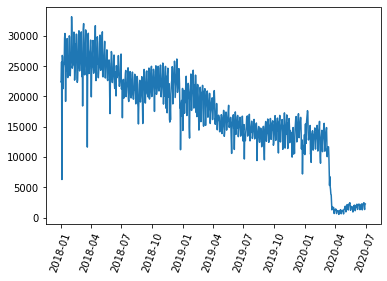

In [17]:
#ridership timeline - daily trip counts; seem to decline and particularly during the pandemics lockdown
plt.plot(dfTaxiDaily['Date'], dfTaxiDaily['trip_count'])
plt.xticks(rotation=70);
plt.show()

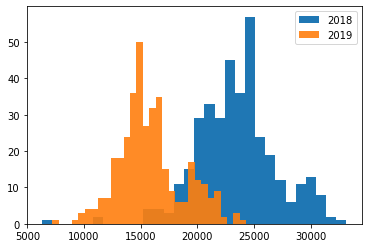

In [18]:
#histograms of daily counts in 2019 and 2018 - distributions look different
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'].values,bins=30,label='2018')
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'].values,bins=30,alpha=0.9,label='2019')
#plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.5,label='2020')
plt.legend()

In [19]:
## t-test between the 2019 and 2018 distributions
stats.ttest_ind(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

Ttest_indResult(statistic=32.155781291624635, pvalue=7.181870622808444e-142)

In [20]:
## K-S test
stats.ks_2samp(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

Ks_2sampResult(statistic=0.7726027397260274, pvalue=1.0796371035959268e-107)

So the hypothesis that 2018 and 2019 daily trip counts follow the same distributions can be rejected beyond any reasonable doubt

In [21]:
#For further analysis select the year 2019
dfTaxiDaily2019 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2019] #daily aggregates
dfTaxi2019 = dfTaxi.loc[dfTaxi['Year']==2019] #individual trips
(dfTaxiDaily2019['trip_count'].sum(),len(dfTaxi2019)) #total trip counts in either dataset

(5797411, 5797411)

## Example 1. Test if weekend ridership is different from weekday

In [22]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# t-test
stats.ttest_ind(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<4]['trip_count'])

Ttest_indResult(statistic=-2.1367615679779988, pvalue=0.033397463681736655)

In [23]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# KS-test
stats.ks_2samp(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<4]['trip_count'])

Ks_2sampResult(statistic=0.22188995215311005, pvalue=0.001823856491109277)

Reject the hypothesis that weekends and weekdays follow the same ridership distribution at 95\% significance level

## Example 2. Test if trip speed, duration or distance follow log-normal distributions

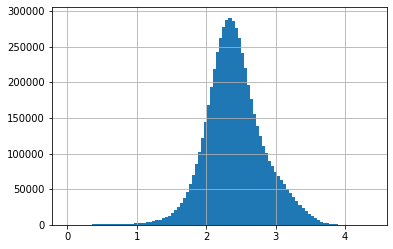

In [24]:
#analyze the overall speed distribution (plot on log-scale)
np.log(dfTaxi2019['speed']).hist(bins=100)

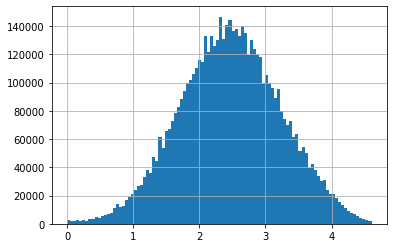

In [25]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_duration']).hist(bins=100)

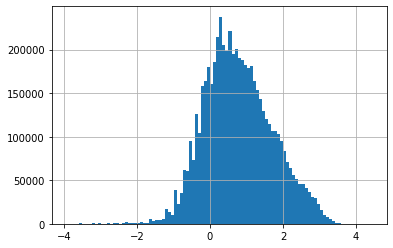

In [26]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_distance']).hist(bins=100)

In [27]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [28]:
# is log-speed normally distributed?
is_normal(np.log(dfTaxi2019['speed']))

KstestResult(statistic=0.040518371390364294, pvalue=0.0)

In [29]:
# is log-duration normally distributed?
is_normal(np.log(dfTaxi2019['trip_duration']))

KstestResult(statistic=0.006451584004767197, pvalue=5.080860790642271e-210)

In [30]:
# is log-distance normally distributed?
is_normal(np.log(dfTaxi2019['trip_distance']))

KstestResult(statistic=0.03730364171588013, pvalue=0.0)

In [31]:
#so none of those quantities have log-normal distribution (rejecting with 99.9999...% confidence)

In [32]:
#what about daily average trip_count, duration, distance, speed?

In [33]:
is_normal(dfTaxiDaily2019['trip_count']) #does not look normal

KstestResult(statistic=0.09130133668490537, pvalue=0.004250604464942299)

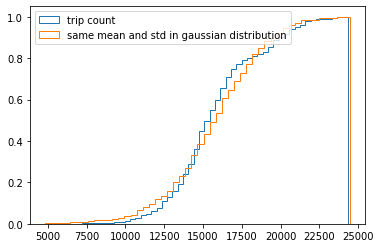

In [34]:
#visualize empiric CDF's for trip-counts
plt.hist(dfTaxiDaily2019['trip_count'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip count')
plt.hist(np.random.normal(dfTaxiDaily2019['trip_count'].mean(), dfTaxiDaily2019['trip_count'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [35]:
is_normal(np.log(dfTaxiDaily2019['trip_count'])) #but might be log-normal

KstestResult(statistic=0.06338499338725434, pvalue=0.10199069022894074)

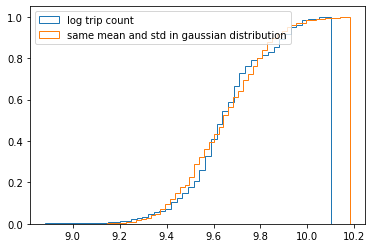

In [36]:
#visualize empiric CDF's for log trip-counts
plt.hist(np.log(dfTaxiDaily2019['trip_count'].values), 50, density=True, 
         histtype='step',cumulative=True,label='log trip count')
plt.hist(np.random.normal(np.log(dfTaxiDaily2019['trip_count']).mean(), np.log(dfTaxiDaily2019['trip_count']).std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [37]:
is_normal(dfTaxiDaily2019['trip_duration']) #could be normal

KstestResult(statistic=0.04874594434156132, pvalue=0.3416989433151879)

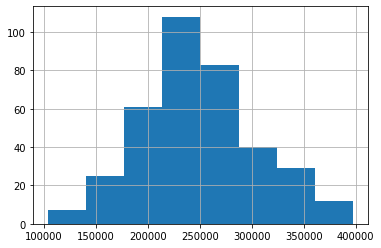

In [38]:
dfTaxiDaily2019['trip_duration'].hist(bins=8)

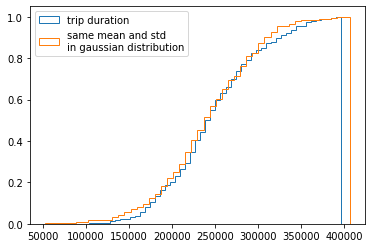

In [39]:
_ = plt.hist(dfTaxiDaily2019['trip_duration'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip duration')
_ = plt.hist(np.random.normal(dfTaxiDaily2019['trip_duration'].mean(), 
                              dfTaxiDaily2019['trip_duration'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std \nin gaussian distribution')
plt.legend(loc='upper left')

In [40]:
is_normal(dfTaxiDaily2019['trip_distance']) #does not look normal

KstestResult(statistic=0.10293939455876078, pvalue=0.0008049522811456512)

In [41]:
is_normal(np.log(dfTaxiDaily2019['trip_distance'])) #but might be log-normal

KstestResult(statistic=0.06677986532907287, pvalue=0.07367146283433422)

In [42]:
is_normal(dfTaxiDaily2019['speed']) #might be normal

KstestResult(statistic=0.0683576711671553, pvalue=0.0629717636318335)

In [43]:
is_normal(np.log(dfTaxiDaily2019['speed'])) #log-normal even more likely

KstestResult(statistic=0.060066857847081156, pvalue=0.13789000584955083)

## Homework assignment

## Task 1. Travel speed - hours of the day
Traffic and travel speed might vary throughout the day. Select the trips happening on Oct, 1, 2019. a) Compute average travel speed per each hour of the day and visuale as a bar plot. Compare the speed distributions for: b) trip samples within an hour of 9am (Hour=9) and an hour of 10am, c) morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18)). Can you reject the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95\% significance level?

In [44]:
dfTaxiSample = dfTaxi2019.loc [ dfTaxi2019['Date'] == pd.to_datetime('Oct, 1, 2019') ]
len(dfTaxiSample)

13579

In [45]:
dfTaxiSample['daytime'] = 0
dfTaxiSample.loc[dfTaxi2019['Hour'].between(6,18),'daytime'] = 1

In [46]:
dfTaxiSampleHourly = dfTaxiSample.groupby(['Hour']).agg({'trip_distance':'sum','trip_duration':'sum'})
dfTaxiSampleHourly['speed'] = dfTaxiSampleHourly['trip_distance'] / (dfTaxiSampleHourly['trip_duration'] / 60)

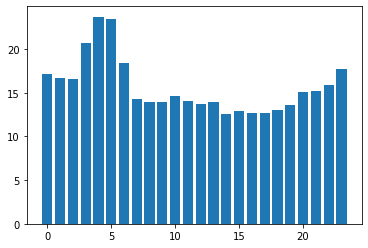

In [48]:
##SS crashes here replaced by hourly
p = plt.bar(dfTaxiSampleHourly.index,dfTaxiSampleHourly['speed'])

In [49]:
stats.ttest_ind(dfTaxiSample.loc[dfTaxiSample['Hour'].between(9,9)]['speed'],
                dfTaxiSample.loc[dfTaxiSample['Hour'].between(10,10)]['speed'])

Ttest_indResult(statistic=-1.173277394807621, pvalue=0.2408567402829922)

In [50]:
stats.ks_2samp(dfTaxiSample.loc[dfTaxiSample['Hour'].between(9,9)]['speed'],
                dfTaxiSample.loc[dfTaxiSample['Hour'].between(10,10)]['speed'])

Ks_2sampResult(statistic=0.04866545344252351, pvalue=0.2793212653142775)

In [51]:
stats.ttest_ind(np.log(dfTaxiSample.loc[dfTaxiSample['Hour'].between(8,9)]['speed']),
                np.log(dfTaxiSample.loc[dfTaxiSample['Hour'].between(17,18)]['speed']))

Ttest_indResult(statistic=4.398437926509444, pvalue=1.1225893586594122e-05)

In [52]:
stats.ks_2samp((dfTaxiSample.loc[dfTaxiSample['Hour'].between(8,9)]['speed']),
                (dfTaxiSample.loc[dfTaxiSample['Hour'].between(17,18)]['speed']))

Ks_2sampResult(statistic=0.06860517517057287, pvalue=0.0005164093592924246)

## Task 2. Travel speed - days of the week
Traffic and travel speed also vary during different weekdays. a) Compute average travel speed per each of the 7 days of the week (among all the individual trips happening on Mondays, Tuesdays, Wednesdays etc); visualize those as a bar plot. Then compute average travel speed per each day of the year and perform a pairwise comparison between the distributions of the daily speed averages within different days of the week (i.e. distribution of all Mondays vs all Tuesdays etc). Compute p-value of the ks-test for each pair of the different weekdays and compare with 5\%. As a results we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5\%), "keep" (if p-value above 5\%) and "-" on the diagonal.

In [53]:
dfTaxiDaily2019['speed'] = dfTaxiDaily2019['trip_distance'] / (dfTaxiDaily2019['trip_duration'] / 60)
dfTaxiDaily2019.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
369,2019,1,1,2019-01-01,14390,192711.466667,53902.06,16.782206
374,2019,1,2,2019-01-02,18006,271243.283333,65946.40,14.587583
379,2019,1,3,2019-01-03,19864,309704.316667,72163.08,13.980382
384,2019,1,4,2019-01-04,21004,319137.216667,74342.63,13.976928
388,2019,1,5,2019-01-05,19386,258513.416667,63392.53,14.713170


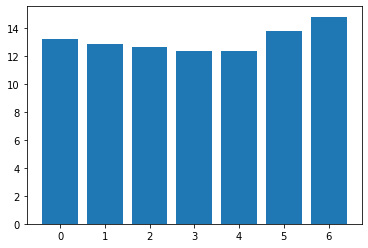

In [54]:
dfTaxiSampleDOW = dfTaxiDaily2019.groupby(['DOW']).agg({'trip_distance':'sum','trip_duration':'sum'})
dfTaxiSampleDOW['speed'] = dfTaxiSampleDOW['trip_distance'] / (dfTaxiSampleDOW['trip_duration'] / 60)
p = plt.bar(dfTaxiSampleDOW.index,dfTaxiSampleDOW['speed'])

In [55]:
p = pd.DataFrame([[stats.ks_2samp(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']==d1]['speed'],
                               dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']==d2]['speed']).\
               pvalue for d1 in range (0,7)] for d2 in range (0,7)]) <= 0.05

In [56]:
p = ((p + 1) * (1 - np.eye(7))).replace(1,'Keep').replace(2,'Reject').replace(0,'-')
p

,0,1,2,3,4,5,6
0,-,Keep,Reject,Reject,Reject,Reject,Reject
1,Keep,-,Reject,Reject,Reject,Reject,Reject
2,Reject,Reject,-,Reject,Keep,Reject,Reject
3,Reject,Reject,Reject,-,Keep,Reject,Reject
4,Reject,Reject,Keep,Keep,-,Reject,Reject
5,Reject,Reject,Reject,Reject,Reject,-,Reject
6,Reject,Reject,Reject,Reject,Reject,Reject,-


## Task 3. Trip speeds per borough.

For the day of Oct, 1, 2019 compute the average trip speed in Brooklyn, Queens and Bronx (by pickup). Then compare the samples of the trip speeds in Brooklyn, Queens and Bronx on that day using t-test and ks-test (pairwise comparison). Fill two 3x3 pandas dataframes (one for t-test, one for ks-test) with p-values for each pair of boroughs. Can we reject the null hypothesis that speed mean/distributions within each pair of boroughs is is similar?

HINT: Download taxizone geojson from 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON' to define borough for each pickup taxi zone.

In [57]:
# download taxizone map
file = 'taxizone.geojson'
url = 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON'
urllib.request.urlretrieve(url,'Data/TLC/'+file)

('Data/TLC/taxizone.geojson', <http.client.HTTPMessage at 0x1a4d8bdb10>)

In [58]:
taxizone = gpd.read_file('Data/TLC/taxizone.geojson')
taxizone.head()

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."


In [59]:
zonetoBoro = pd.Series(taxizone.borough.values,index=taxizone.location_id).to_dict()
dfTaxiSample['PUZone'] = dfTaxiSample.PULocationID.apply(lambda x:zonetoBoro[str(x)] if str(x) in zonetoBoro else 'None')
dfTaxiSample['DOZone'] = dfTaxiSample.DOLocationID.apply(lambda x:zonetoBoro[str(x)] if str(x) in zonetoBoro else 'None')

In [60]:
p = pd.DataFrame([[stats.ttest_ind(dfTaxiSample.loc[dfTaxiSample['PUZone']==b1]['speed'],
                               dfTaxiSample.loc[dfTaxiSample['PUZone']==b2]['speed']).\
               pvalue for b1 in ['Brooklyn','Queens','Bronx']] for b2 in ['Brooklyn','Queens','Bronx']],
                 columns = ['Brooklyn','Queens','Bronx'],index = ['Brooklyn','Queens','Bronx'],)
p

,Brooklyn,Queens,Bronx
Brooklyn,1.000000e+00,1.879582e-15,3.834652e-36
Queens,1.879582e-15,1.000000e+00,5.891792e-12
Bronx,3.834652e-36,5.891792e-12,1.000000e+00


In [61]:
p = pd.DataFrame([[stats.ks_2samp(dfTaxiSample.loc[dfTaxiSample['PUZone']==b1]['speed'],
                               dfTaxiSample.loc[dfTaxiSample['PUZone']==b2]['speed']).\
               pvalue for b1 in ['Brooklyn','Queens','Bronx']] for b2 in ['Brooklyn','Queens','Bronx']],
                columns = ['Brooklyn','Queens','Bronx'],index = ['Brooklyn','Queens','Bronx'],)
p

,Brooklyn,Queens,Bronx
Brooklyn,1.000000e+00,1.000000e+00,4.073554e-37
Queens,1.000000e+00,1.000000e+00,4.319099e-13
Bronx,4.073554e-37,4.319099e-13,1.000000e+00


In [72]:
#you may have noticed that Brooklyn vs Queens ks-test p-value is returned as 1.0. This is clearly wrong
#a weird artifact of ks_2samp - sometimes returns p-value 1.0 where it should not; as we see KS-statistics is far from zero
#more on this bug here: https://github.com/scipy/scipy/issues/11184
stats.ks_2samp(dfTaxiSample.loc[dfTaxiSample['PUZone']=='Queens']['speed'],
                               dfTaxiSample.loc[dfTaxiSample['PUZone']=='Brooklyn']['speed'])

Ks_2sampResult(statistic=0.1119625150584084, pvalue=1.0)

We can see all borough pairwise comparison p-values pretty low, so all three distributions appear to be statistically different. The t-test p-value between Brooklyn and Queens is somewhat higher but still quite low. Is there a better way to assess how exactly different are the means?

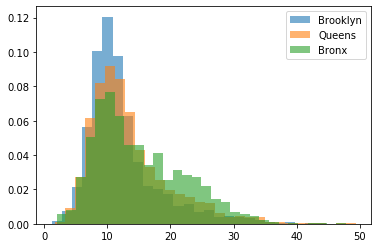

In [70]:
## COMPLEMENTARY ANALYSIS (not required in the assignment)
#speed distributions in the three boroughs look different indeed
plt.hist(dfTaxiSample.loc[dfTaxiSample['PUZone']=='Brooklyn']['speed'],bins=30,density=True,alpha=0.6,label='Brooklyn')
plt.hist(dfTaxiSample.loc[dfTaxiSample['PUZone']=='Queens']['speed'],bins=30,density=True,alpha=0.6,label='Queens')
plt.hist(dfTaxiSample.loc[dfTaxiSample['PUZone']=='Bronx']['speed'],bins=30,density=True,alpha=0.6,label='Bronx')
plt.legend()

In [76]:
def mean_ci(x, c=0.95): #returns confidence interval for the sample mean estimate
    #assumes t-distribution for the sample mean
    return stats.t.interval(c, len(x)-1, loc=np.mean(x), scale=stats.sem(x))

In [77]:
#estimate for the average speed in Brooklyn
#interval where it belongs with 95% confidence
mean_ci(dfTaxiSample.loc[dfTaxiSample['PUZone']=='Brooklyn']['speed'])

(12.233187589986466, 12.60894306141701)

In [78]:
#estimate for the average speed in Queens
#interval where it belongs with 95% confidence
mean_ci(dfTaxiSample.loc[dfTaxiSample['PUZone']=='Queens']['speed'])

(13.3544426185012, 13.775388715852507)

In [79]:
#estimate for the average speed in Bronx
#interval where it belongs with 95% confidence
mean_ci(dfTaxiSample.loc[dfTaxiSample['PUZone']=='Bronx']['speed'])

(14.739362886663796, 15.619417294046317)

Confidence itervals for the the average speed in boroughs do not overlap (there is no value that is likely to serve as a common average for any two boroughs), so the average speeds in Boroughs are signifinatly different 

# Task 4. Ridership drop during pandemics
No doubt that 2020 saw a large drop in ridership but how can we assess it? Keep in mind that we don't have the full year, the drop just started in March and there is also a general decline in taxi ridership, so we need a way to distinguish pandemics-related drop from the general trend. In order to account for it, normalize 2020 daily ridership data by the same day's 30-days rolling average (15 days before/after to smoothen out the effect of weekly variations within the baseline) in 2019, and compare the daily ratios of ridership after the shelter in place order (Mar 20th till June, 30th, 2020) and before (Jan, 16-Mar, 20th, 2020). Report p-values of ks-test and t-test. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2020 is the same as before? For comparison and to provide a baseline for evaluating results of the hypothesis testing perform the same analysis for the same periods of 2019. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2019 is the same as before?

In [102]:
#and extract month and day from the date for 2019 daily trip count
dfTaxiDaily2019['Date'] = pd.to_datetime(dfTaxiDaily2019['Date'])
dfTaxiDaily2019['Month'] = dfTaxiDaily2019.Date.dt.month
dfTaxiDaily2019['Day'] = dfTaxiDaily2019.Date.dt.day
#dfTaxiDaily2019.head()

In [83]:
#prepare daily 2020 daily trip data
dfTaxiDaily2020 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]
dfTaxiDaily2020['Date'] = pd.to_datetime(dfTaxiDaily2020['Date'])
dfTaxiDaily2020['Month'] = dfTaxiDaily2020.Date.dt.month
dfTaxiDaily2020['Day'] = dfTaxiDaily2020.Date.dt.day
dfTaxiDaily2020.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Day
738,2020,1,2,2020-01-01,10410,146795.583333,42825.83,17.504272,1
743,2020,1,3,2020-01-02,14440,241500.683333,61940.19,15.388824,2
748,2020,1,4,2020-01-03,15463,252003.183333,62165.15,14.801039,3
753,2020,1,5,2020-01-04,13797,205190.250000,54313.63,15.881933,4
757,2020,1,6,2020-01-05,12255,176122.633333,49472.43,16.853858,5


In [84]:
#prepare daily 2018 daily trip data
dfTaxiDaily2018 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]
dfTaxiDaily2018['Date'] = pd.to_datetime(dfTaxiDaily2018['Date'])
dfTaxiDaily2018['Month'] = dfTaxiDaily2018.Date.dt.month
dfTaxiDaily2018['Day'] = dfTaxiDaily2018.Date.dt.day
dfTaxiDaily2018.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Day
0,2018,1,0,2018-01-01,22423,264304.966667,68020.99,15.441478,1
5,2018,1,1,2018-01-02,22612,274769.883333,59582.22,13.010644,2
10,2018,1,2,2018-01-03,25687,342076.633333,69511.54,12.192275,3
15,2018,1,3,2018-01-04,6298,80906.850000,16407.39,12.167615,4
19,2018,1,4,2018-01-05,26774,341913.516667,64378.27,11.297290,5


In [85]:
#assess rolling average for 2019 trip count
dfTaxiDaily2019['2019rolling_trip_count'] = dfTaxiDaily2019['trip_count'].rolling(30,center=True).mean()
dfTaxiDaily2019.dropna(inplace=True)

In [86]:
#assess rolling average for 2018 trip count
dfTaxiDaily2018['2018rolling_trip_count'] = dfTaxiDaily2018['trip_count'].rolling(30,center=True).mean()
dfTaxiDaily2018.dropna(inplace=True)

In [90]:
#2019 to 2018 rolling average daily trip ratio
dfTaxiDaily2019Ratio = dfTaxiDaily2019.merge(dfTaxiDaily2018[['Month','Day','2018rolling_trip_count']],on=['Month','Day'])
dfTaxiDaily2019Ratio['trip_count_ratio'] = dfTaxiDaily2019Ratio['trip_count'] / dfTaxiDaily2019Ratio['2018rolling_trip_count']
dfTaxiDaily2019Ratio.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,2019rolling_trip_count,Day,2018rolling_trip_count,trip_count_ratio
0,2019,1,3,2019-01-31,20615,314955.916667,69815.24,13.300002,20257.500000,31,26551.333333,0.776421
1,2019,2,4,2019-02-01,24334,386955.150000,82031.33,12.719510,20289.566667,1,26668.300000,0.912469
2,2019,2,5,2019-02-02,21925,311253.000000,72423.76,13.961072,20215.433333,2,26859.300000,0.816291
3,2019,2,6,2019-02-03,18084,255064.516667,65647.22,15.442498,20049.866667,3,26972.966667,0.670449
4,2019,2,0,2019-02-04,19650,333498.866667,74428.33,13.390450,19875.166667,4,26759.833333,0.734310


In [91]:
#2020 to 2019 rolling average daily trip ratio
dfTaxiDaily2020Ratio = dfTaxiDaily2020.merge(dfTaxiDaily2019[['Month','Day','2019rolling_trip_count']],on=['Month','Day'])
dfTaxiDaily2020Ratio['trip_count_ratio'] = dfTaxiDaily2020Ratio['trip_count'] / dfTaxiDaily2020Ratio['2019rolling_trip_count']
dfTaxiDaily2020Ratio.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,Day,2019rolling_trip_count,trip_count_ratio
0,2020,1,4,2020-01-31,14810,236643.566667,51143.93,12.967332,31,20257.500000,0.731087
1,2020,2,5,2020-02-01,12410,171041.066667,42034.93,14.745557,1,20289.566667,0.611644
2,2020,2,6,2020-02-02,11318,155694.233333,40678.39,15.676261,2,20215.433333,0.559869
3,2020,2,0,2020-02-03,12750,200905.400000,45921.91,13.714488,3,20049.866667,0.635914
4,2020,2,1,2020-02-04,13241,214757.966667,49131.26,13.726502,4,19875.166667,0.666208


In [92]:
# 2020 ratios before and after lockdown: t-test
stats.ttest_ind(dfTaxiDaily2020Ratio.loc[dfTaxiDaily2020Ratio['Date']<pd.Timestamp(2020,3, 20)]['trip_count_ratio'],
                               dfTaxiDaily2020Ratio.loc[dfTaxiDaily2020Ratio['Date']>=pd.Timestamp(2020, 3, 20)]['trip_count_ratio']).pvalue

3.714958403160484e-71

In [95]:
# 2020 ks-test
stats.ks_2samp(dfTaxiDaily2020Ratio.loc[dfTaxiDaily2020Ratio['Date']<pd.Timestamp(2020,3, 20)]['trip_count_ratio'],
                               dfTaxiDaily2020Ratio.loc[dfTaxiDaily2020Ratio['Date']>=pd.Timestamp(2020, 3, 20)]['trip_count_ratio']).pvalue

9.992007221626409e-16

So the null hypothesis that the ratios before and after lockdown follow the same distribution or have the same average can be rejected beyond any reasonable doubt

In [ ]:
# 2019 baseline

In [93]:
stats.ttest_ind(dfTaxiDaily2019Ratio.loc[dfTaxiDaily2019Ratio['Date']<pd.Timestamp(2019,3, 20)]['trip_count_ratio'],
                               dfTaxiDaily2019Ratio.loc[dfTaxiDaily2019Ratio['Date']>=pd.Timestamp(2019, 3, 20)]['trip_count_ratio']).pvalue

6.62214687545e-12

In [96]:
stats.ks_2samp(dfTaxiDaily2019Ratio.loc[dfTaxiDaily2019Ratio['Date']<pd.Timestamp(2019,3, 20)]['trip_count_ratio'],
                               dfTaxiDaily2019Ratio.loc[dfTaxiDaily2019Ratio['Date']>=pd.Timestamp(2019, 3, 20)]['trip_count_ratio']).pvalue

2.5524904412321803e-10

However the baseline analysis for the same period of 2019 would also reject the null-hypothesis. So it looks like the distributions are different simply because the periods are different, might have nothing to do with the lockdown actually. Although p-values are noticeably higher. To get some sense of what is going on with the ratios let's assess the sample means with confidence intervals as above

In [103]:
## COMPLEMENTARY ANALYSIS (not required in the assignment)
#average trip count drop in 2020 vs 2019 before the lockdown
mean_ci(dfTaxiDaily2020Ratio.loc[dfTaxiDaily2020Ratio['Date']<pd.Timestamp(2020,3, 20)]['trip_count_ratio'])

(0.5699922275475071, 0.6550574311085797)

In [104]:
#average trip count drop in 2020 vs 2019 before after the lockdown
mean_ci(dfTaxiDaily2020Ratio.loc[dfTaxiDaily2020Ratio['Date']>=pd.Timestamp(2020,3, 20)]['trip_count_ratio'])

(0.09478885494302347, 0.10870804509295712)

In [105]:
#average trip count drop in 2019 vs 2018 before March, 20 (same date for comparison)
mean_ci(dfTaxiDaily2019Ratio.loc[dfTaxiDaily2019Ratio['Date']<pd.Timestamp(2019, 3, 20)]['trip_count_ratio'])

(0.710912899097271, 0.7592905587797857)

In [106]:
#average trip count drop in 2019 vs 2018 after March, 20 (same date for comparison)
mean_ci(dfTaxiDaily2019Ratio.loc[dfTaxiDaily2019Ratio['Date']>=pd.Timestamp(2019, 3, 20)]['trip_count_ratio'])

(0.6431147309820072, 0.6607914893145882)

So while the confidence intervals for the averages indeed do not overlap in either year and it looks like the spring ridership also dropped more significantly in 2019 for some reason, the difference in 2020 is dramatically higher than in 2019. After the lockdown the ridership is only 10\% of the level of 2019, while before the lockdown it was around 60\%.